# Tema : Fundamentos de Regresión y Modelos Estacionarios
![](src/img/logo_utb.png){width=40%} 
![](src/img/logo_etd.png){width=40%}
- **Profesor:**
- **Fernando Salcedo Mejía, Eco Msc.**
- Programa de Ciencias de Datos | Escuela de transformación digital.
- 2026-1

## Ejemplo 2 : El modelo macroeconómico del crecimiento del consumo en Estados Unidos

- Queremos modelar cómo cambia el consumo real (compra de bienes y servicios) de una economía según variables macroeconómicas importantes. El consumo es uno de los componentes más importantes de una economía.

$$
\Delta C_t = \beta_0 + \beta_1 Ingreso_t + \beta_2 Industria_t + \beta_3 Ahorro_t + \beta_4 Desempleo_t + \varepsilon_t
$$

- $\Delta C_t$ es el cambio porcentual en el gasto real de consumo personal.
- $Ingreso_t$​ es el cambio porcentual en el ingreso personal real disponible.
- $Industria_t$​ es el cambio porcentual en la producción industrial.
- $Ahorro_t$​ es el cambio porcentual en el ahorro personal.
- $Desempleo_t$​ es el cambio en la tasa de desempleo.

- Usar el archivo `US_change.csv` para modelar.


## Librerias necesarias

In [38]:
# Instalar todas las librerias necesarias previamente desde r-requirements.txt
library(tidyverse)
library(fable)
library(tsibble)
library(feasts)
library(ggtime)
library(GGally)
library(patchwork)

# tamaño de los graficos
options(repr.plot.width = 10, 
        repr.plot.height = 8,
        repr.plot.res = 300,
        repr.plot.pointsize = 14)

set_theme(theme_bw())

## Cargar datos y exploración

In [2]:
# 1. Cargar y preparar datos
us_change <- read_csv("datos/US_change.csv") |>
  mutate(ds = yearquarter(ds))  |> # Configurar el tiempo de la serie
  as_tsibble(index = ds)

# Encabezado
head(us_change)

Rows: 198 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): unique_id
dbl  (5): y, Income, Production, Savings, Unemployment
date (1): ds

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ds,y,Income,Production,Savings,Unemployment,unique_id
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1970 Q1,0.6185664,1.0448013,-2.4524855,5.299014,0.9,US_change
1970 Q2,0.4519840,1.2256472,-0.5514595,7.789894,0.5,US_change
1970 Q3,0.8728718,1.5851538,-0.3586518,7.403984,0.5,US_change
1970 Q4,-0.2718479,-0.2395449,-2.1856909,1.169898,0.7,US_change
1971 Q1,1.9013450,1.9759249,1.9097644,3.535667,-0.1,US_change
1971 Q2,0.9148773,1.4459085,0.9015695,5.874764,-0.1,US_change


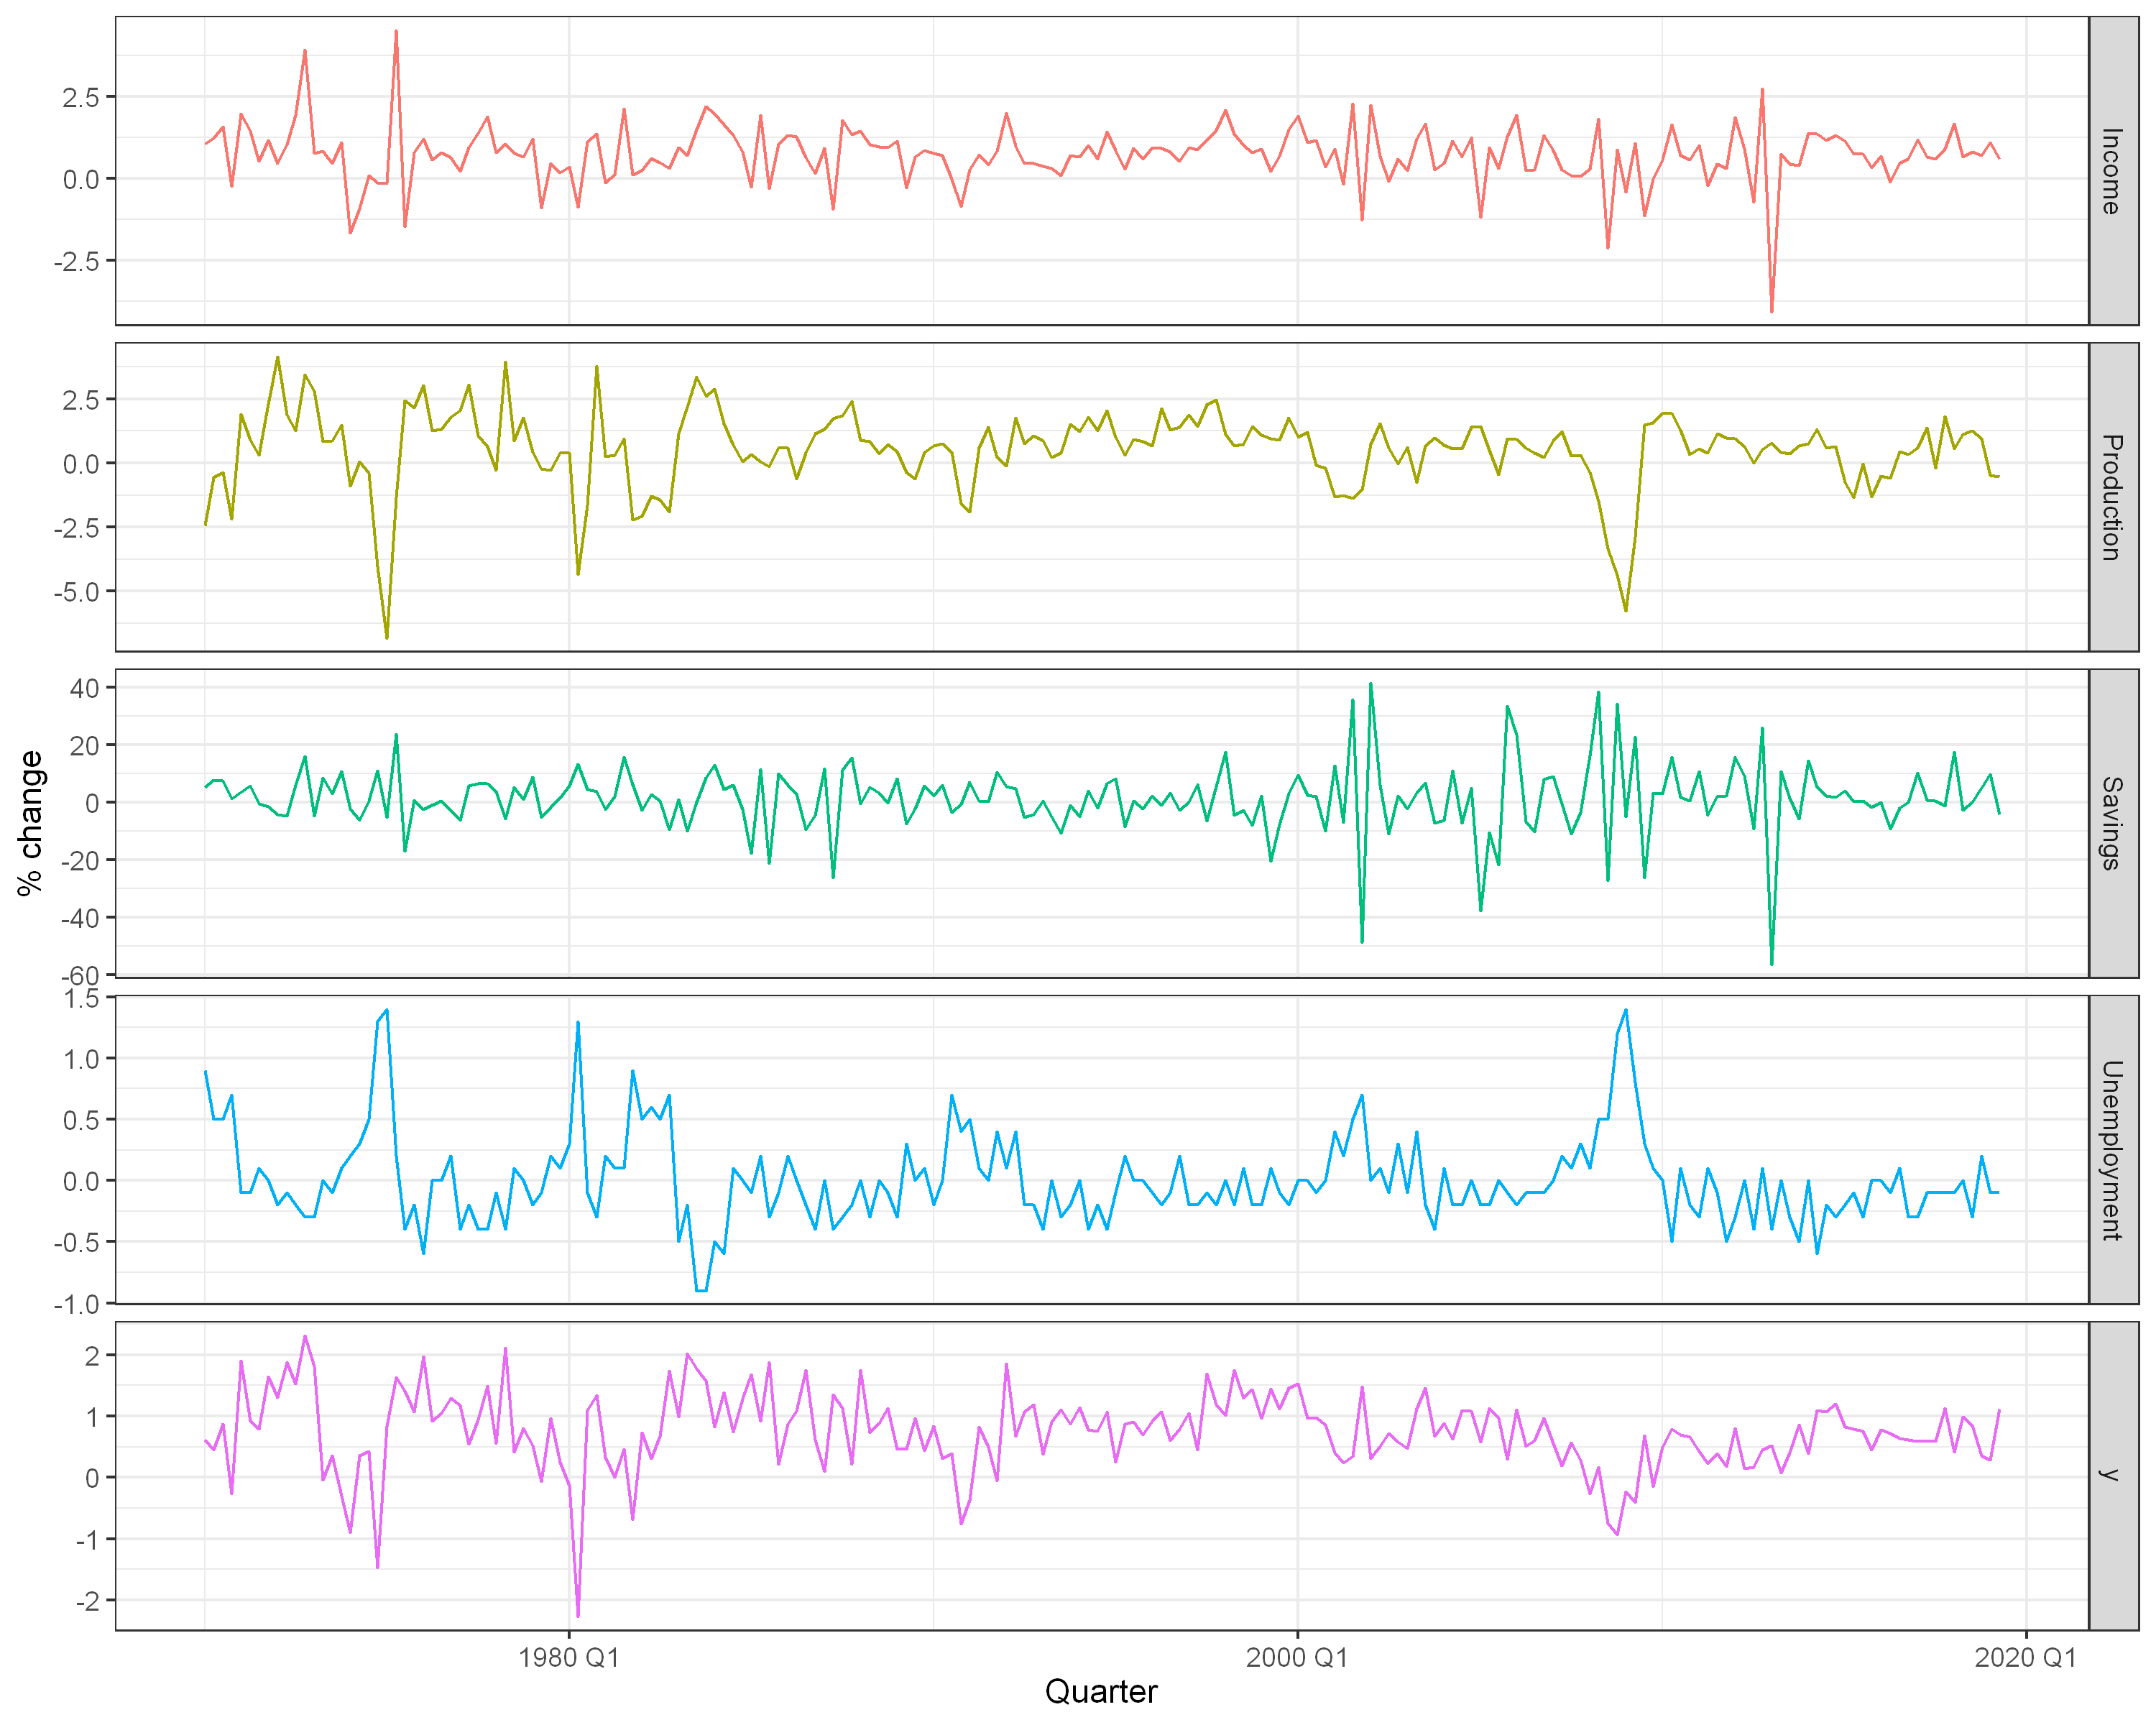

In [29]:
# Visualización
us_change |>
  select(-unique_id) |>
  pivot_longer(-ds) |>
  ggplot(aes(ds, value, colour = name)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") +
  guides(colour = "none") +
  labs(y="% change", x = "Quarter")

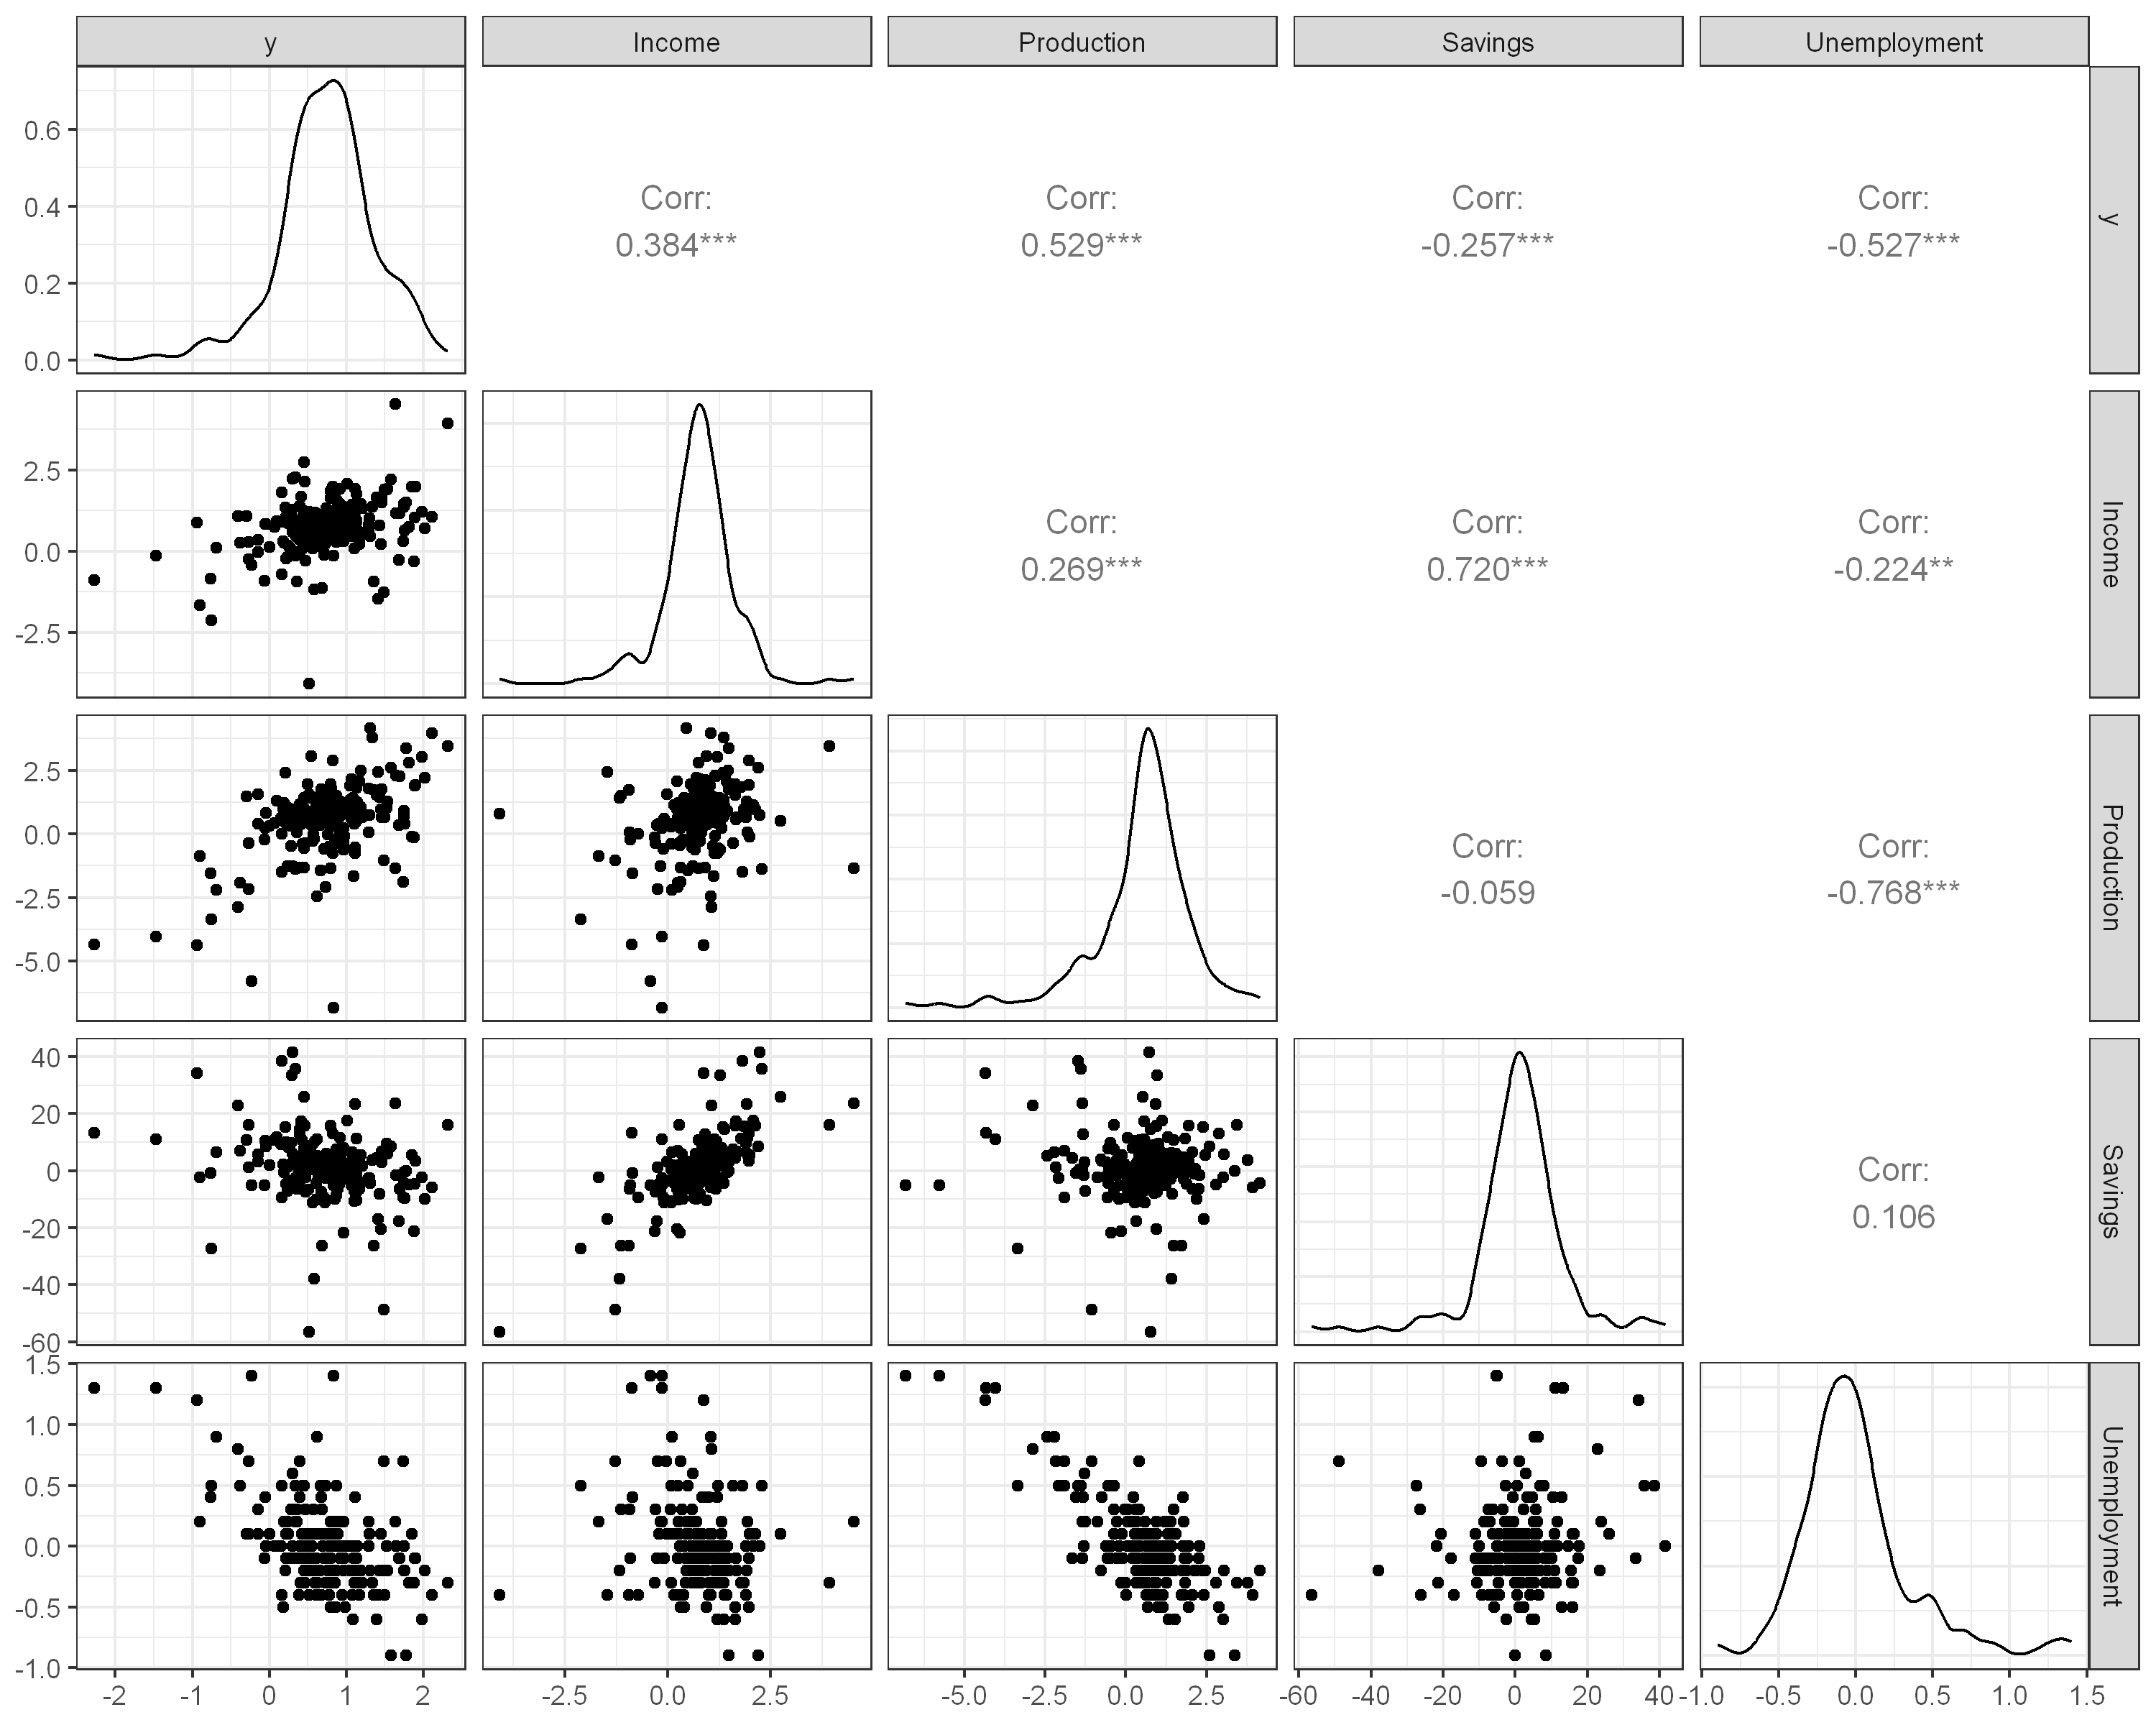

In [30]:
# Grafico de correlación exploratorio
us_change |> ggpairs(columns = 2:6)

## Modelo de regresión lineal MCO por TSLM (Time Series Linear Model) de la librería 'fable'

In [5]:
# Modelo de Regresión Lineal (MCO)
# Usamos TSLM (Time Series Linear Model) de la librería 'fable'
fit <- us_change %>%
  model(
    mco = TSLM(y ~ Income + Production + Savings + Unemployment)
  )

# 4. Resumen del modelo
report(fit)

Series: y 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90555 -0.15821 -0.03608  0.13618  1.15471 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.253105   0.034470   7.343 5.71e-12 ***
Income        0.740583   0.040115  18.461  < 2e-16 ***
Production    0.047173   0.023142   2.038   0.0429 *  
Savings      -0.052890   0.002924 -18.088  < 2e-16 ***
Unemployment -0.174685   0.095511  -1.829   0.0689 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3102 on 193 degrees of freedom
Multiple R-squared: 0.7683,	Adjusted R-squared: 0.7635
F-statistic:   160 on 4 and 193 DF, p-value: < 2.22e-16


## Interpretación del modelo

### Bondad de ajuste : 
- El modelo explica el 76.8% de la variabilidad del cambio del consumo ($R^2$). Es un ajuste aceptable como factores que han explicado la variabilidad del consumo a lo largo de la ventana de observación.
- Al estar el $\text{Adj.} R^2$ con un valor similar al $R^2$ nos indica que las variables explicativas aportan a explicar el comportamiento del cambio del consumo. 
- En su conjunto, el modelo es significativo observando el estadístico $F-statistic$ ya que es prácticamente cero.

### Análisis de coeficientes:
| Variable | Coeficiente | Significancia (p-valor) | Interpretación |
| :--- | :--- | :--- | :--- |
| const | 0.2531 | 0.000 | Si todas las variables fueran 0, el consumo crecería en promedio 0.25% trimestral. |
| Income | 0.7406 | 0.000 | En promedio, por cada 1% que sube el ingreso, el consumo sube un 0.74% trimestral. |
| Production| 0.0472 | 0.043 | Por cada 1% que sube el ingreso, el consumo sube en promedio un 0.047% trimestral. |
| Savings | -0.0529 | 0.000 | Relación inversa. Por cada 1% que sube el ingreso, en promedio el consumo se reduce en un 0.052%. |
| Unemployment| -0.1747 | 0.069 | No significativa al 5%. Su efecto en el consumo no es estadísticamente claro en este modelo. Sin embargo reporta un sentido inverso, lo cual es esperado dado que mayor desempleo, menor ingresos, menor consumo. |


## Ejercicio 3 : 

- Hacer el diagnostico del modelo macroeconómico del crecimiento del consumo en Estados Unidos. ¿Se viola algún supuesto del MCO?


### Linealidad de los parámetros

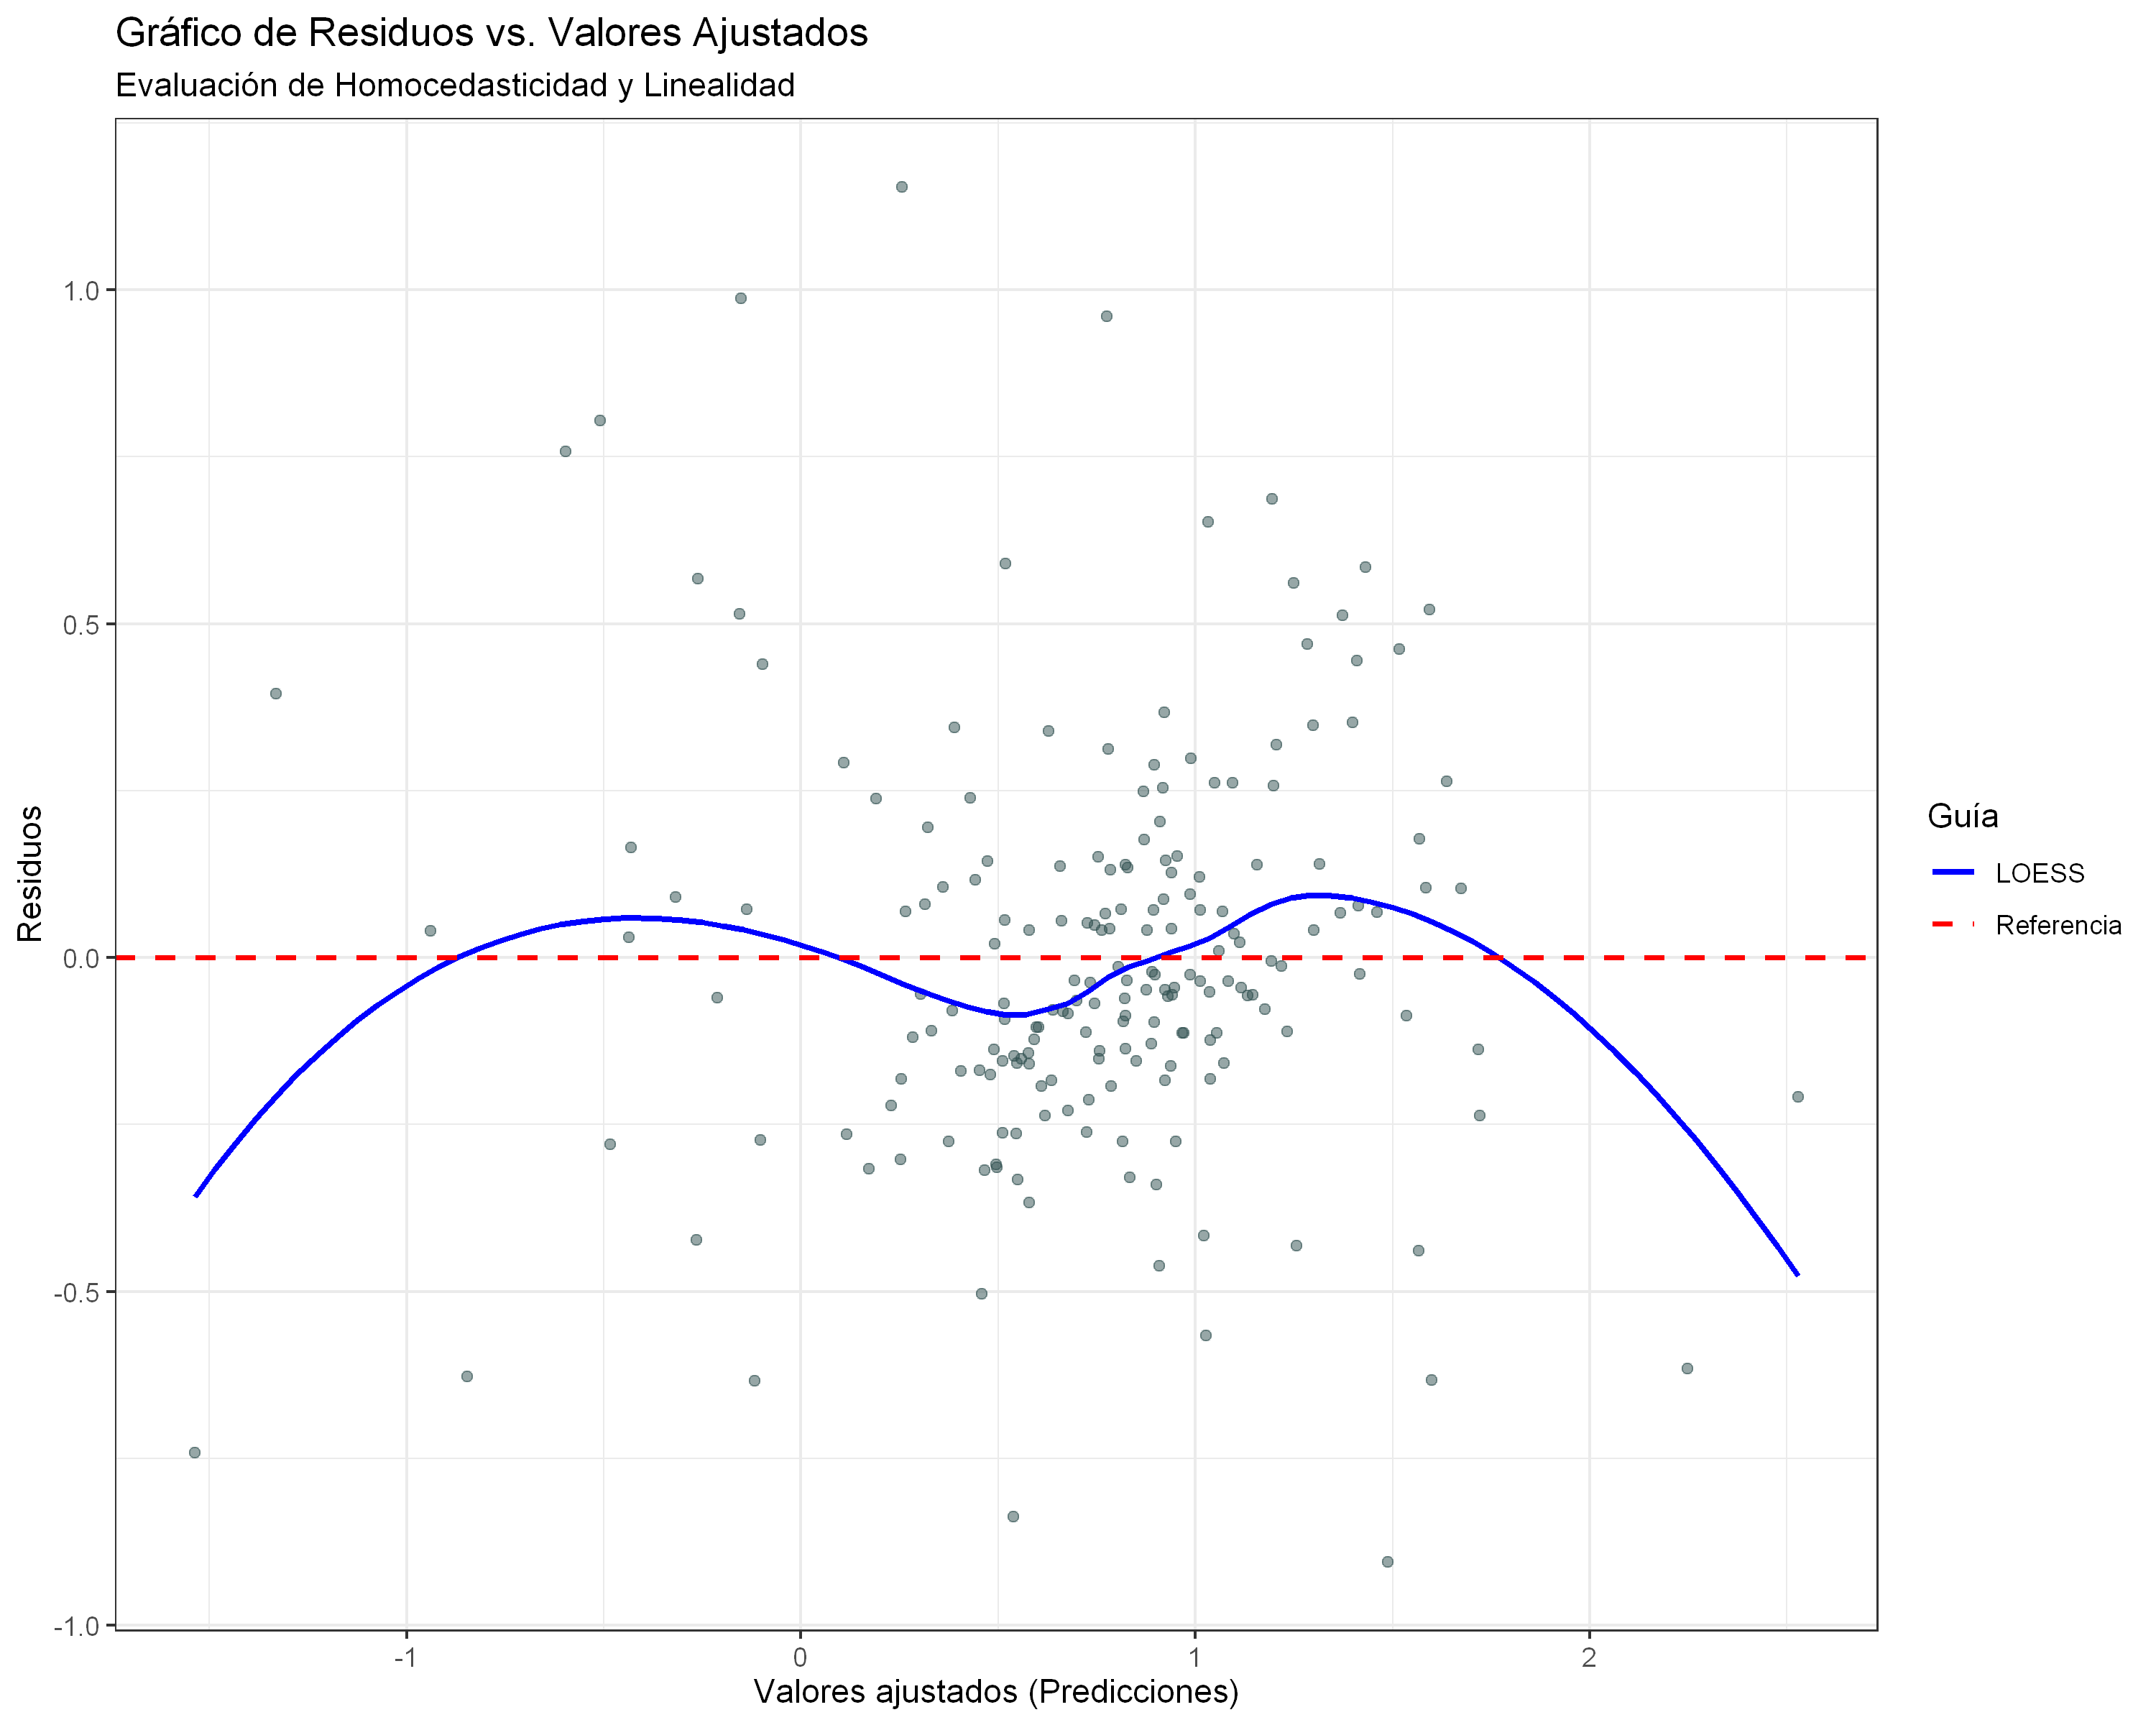

In [37]:
fit |>
  augment() |>
  ggplot(aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.5, color = "darkslategrey") +
  # Línea LOESS para detectar patrones no lineales
  geom_smooth(
    aes(color = "LOESS"), 
    method = "loess", 
    formula = "y ~ x", 
    se = FALSE, 
    linewidth = 1
  ) +
  # Línea de referencia en cero
  geom_hline(
    aes(yintercept = 0, color = "Referencia"), 
    linetype = "dashed", 
    linewidth = 0.8
  ) +
  scale_color_manual(values = c("LOESS" = "blue", "Referencia" = "red")) +
  labs(
    title = "Gráfico de Residuos vs. Valores Ajustados",
    subtitle = "Evaluación de Homocedasticidad y Linealidad",
    x = "Valores ajustados (Predicciones)",
    y = "Residuos",
    color = "Guía"
  )

**Interpretación**

- El gráfico de los valores predichos por el modelo comparados con los residuos, no muestra una relación funcional definida. Podemos concluir que existe una relación lineal de las covariables con el consumo.

### Distribución de los errores son normales

ERROR: Error in jarque.bera.test(resid): no se pudo encontrar la función "jarque.bera.test"


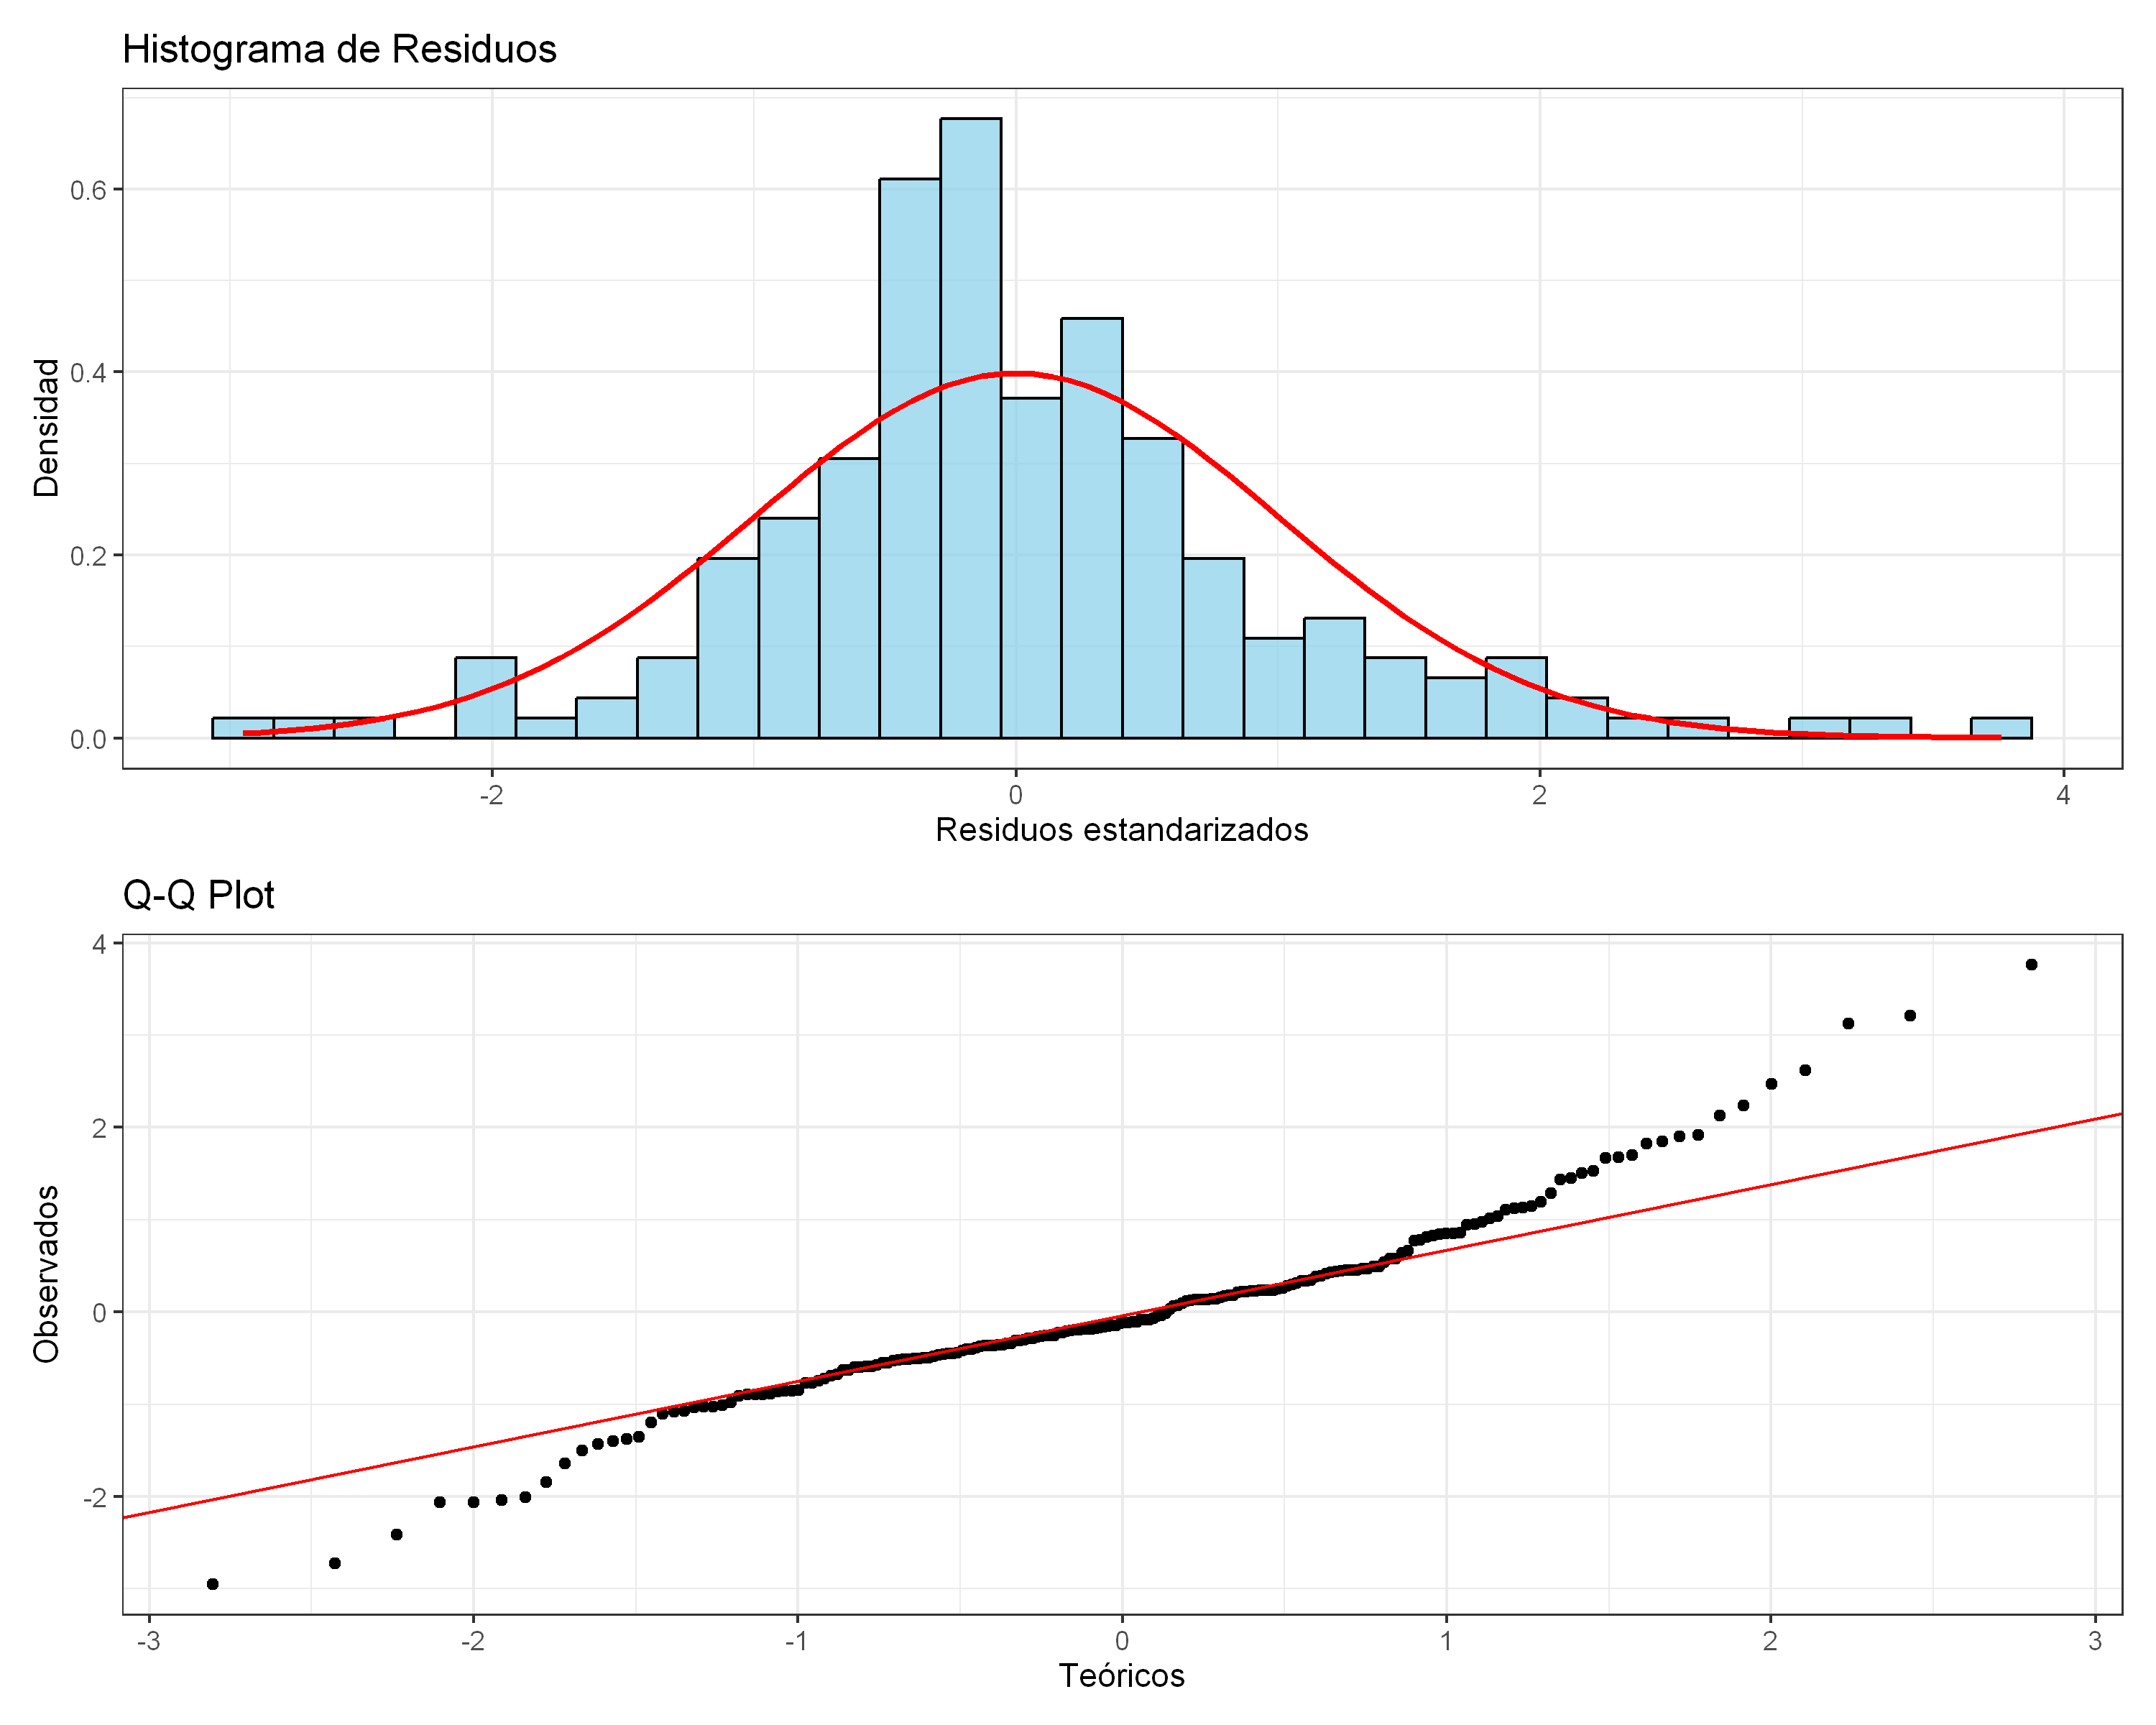

In [55]:
# Extraer residuos y estandarizar
resid <- residuals(fit)$.resid
resid_std <- scale(resid) |> as.numeric()

# GRÁFICO 1: Histograma con curva normal
p1 <- data.frame(res = resid_std) |> 
    ggplot(aes(x = res)) +
    geom_histogram(aes(y = after_stat(density)), bins = 30, 
                   fill = "skyblue", color = "black", alpha = 0.7) +
    stat_function(fun = dnorm, args = list(mean = 0, sd = 1), 
                  color = "red", linewidth = 1) +
    labs(title = "Histograma de Residuos", x = "Residuos estandarizados", y = "Densidad")

p2 <- data.frame(res = resid_std) |> 
    ggplot(aes(sample = res)) +
    stat_qq() +
    stat_qq_line(color = "red") +
    labs(title = "Q-Q Plot", x = "Teóricos", y = "Observados")

p1 / p2
  
# Shapiro-Wilk
sw <- shapiro.test(resid)
# Jarque-Bera
jb <- jarque.bera.test(resid)
# Kolmogorov-Smirnov
ks <- ks.test(resid_std, "pnorm")
# Asimetría y Curtosis
asimetria <- skewness(resid)
curtosis_val <- kurtosis(resid)
  
tab_test <- data.frame(
    test = c("Shapiro-Wilk", "Jarque-Bera", "Kolmogorov-Smirnov", "Asimetría", "Curtosis"),
    estadistico = c(sw$statistic, jb$statistic, ks$statistic, asimetria, curtosis_val),
    p_valor = c(sw$p.value, jb$p.value, ks$p.value, NA, NA)
    ) |> 
  mutate(
    estadistico = round(estadistico, 4),
    p_valor = round(p_valor, 4)
    )
tab_test

### Residuos del modelo con varianza constante (homocedasticos)

### Residuos no está correlacionados

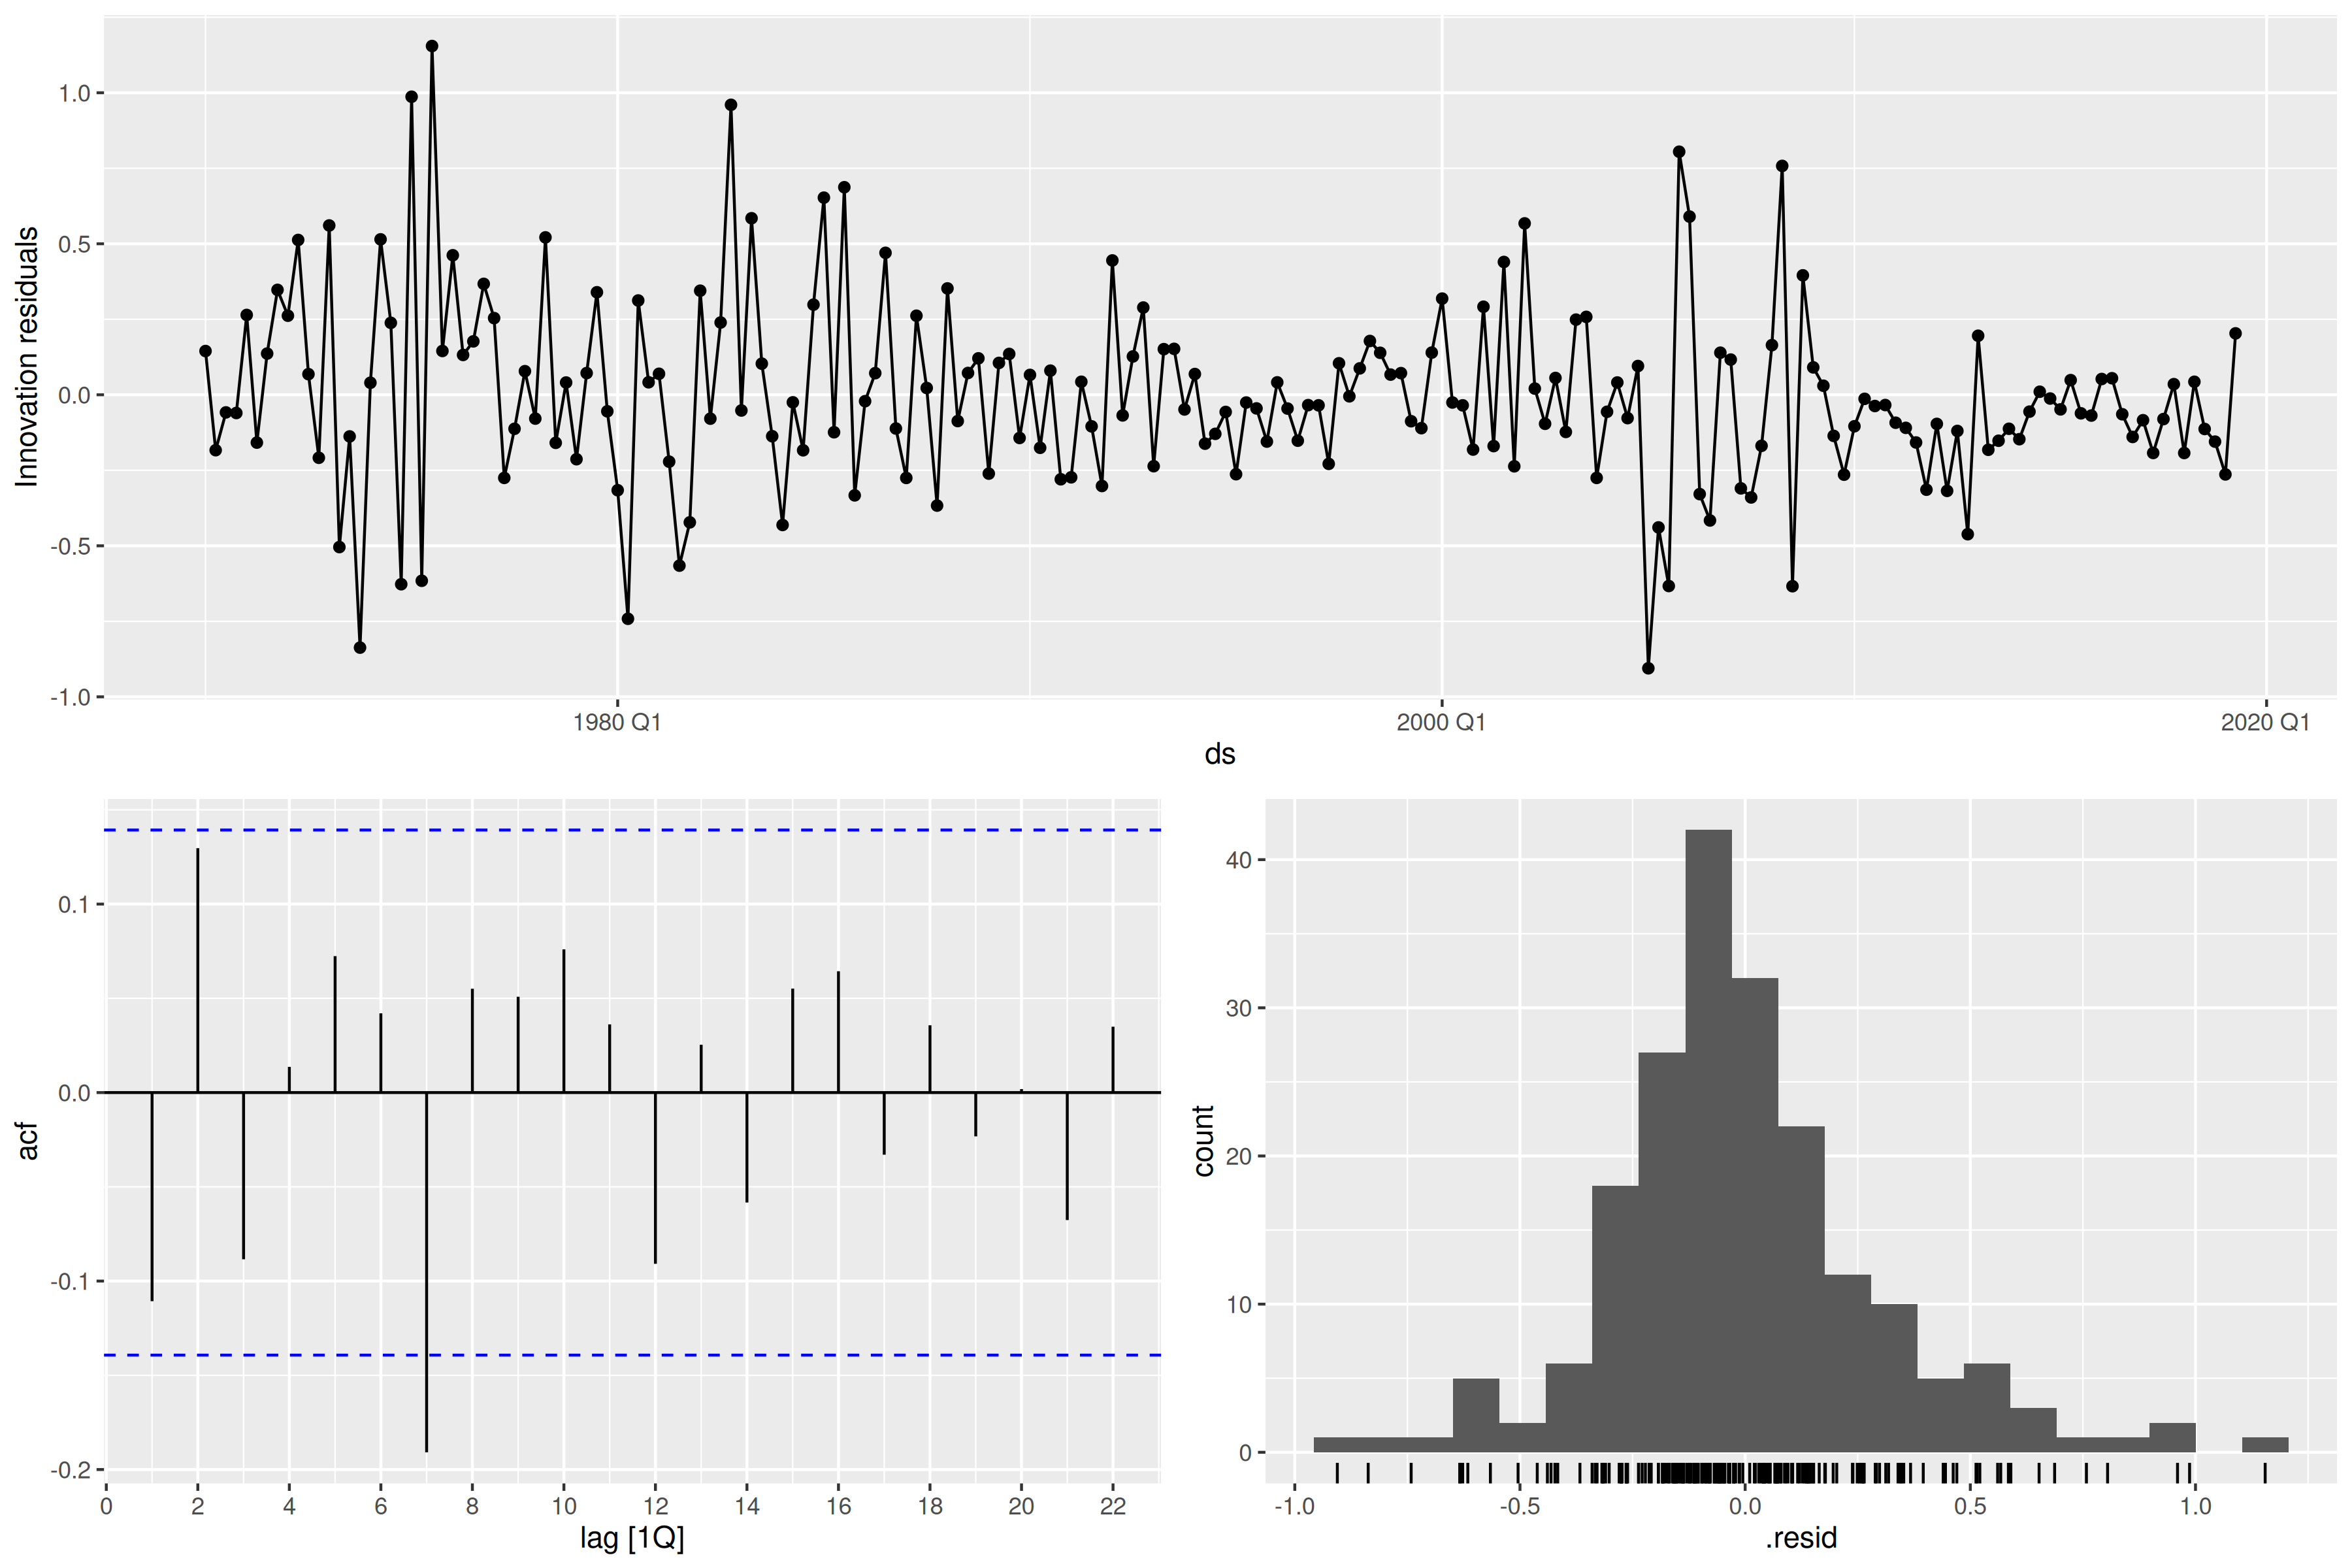

In [6]:
fit %>% gg_tsresiduals()